In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import multilabel_confusion_matrix
from shutil import copyfile
import zipfile
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
import matplotlib.pyplot as plt
%matplotlib inline

FYI:
## Splitting train data into train and validation data for CV loop did not work here in the colored images context?! Guess can work with whatever split they ask in the problem. If you wish to test the performance of the model on unseen data take a fewer images and keep them aside for that purpose and do this while practicing. But in the actual exam guess go with the prompt and not split the data into test to test the final performance.
 

In [4]:
os.getcwd()

'/Users/chidam_sp/PycharmProjects/pythonProject2/Computer vision, Time series, and NLP_TF certification/cats_vs_dogs'

In [5]:
import tensorflow as tf
print(tf.__version__)

2.14.0


In [6]:
# List all available physical devices
physical_devices = tf.config.list_physical_devices()
print("Available physical devices:", physical_devices)

# Specifically check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 0:
    print(f"GPU is available: {gpus}")
else:
    print("GPU is not available.")

Available physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:

# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take some time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/Users/chidam_sp/PycharmProjects/pythonProject2/Convolutional Neural Net_TF/cats-and-dogs.zip"

local_zip = '/Users/chidam_sp/PycharmProjects/pythonProject2/Convolutional Neural Net_TF/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/Users/chidam_sp/PycharmProjects/pythonProject2/Convolutional Neural Net_TF')
zip_ref.close()


--2024-04-05 14:33:47--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.192.208.155
Connecting to download.microsoft.com (download.microsoft.com)|23.192.208.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/Users/chidam_sp/PycharmProjects/pythonProject2/Convolutional Neural Net_TF/cats-and-dogs.zip’

/Users/chidam_sp/Py 100%[===================>] 786.67M  5.90MB/s    in 2m 11s  

2024-04-05 14:35:58 (6.02 MB/s) - ‘/Users/chidam_sp/PycharmProjects/pythonProject2/Convolutional Neural Net_TF/cats-and-dogs.zip’ saved [824887076/824887076]



In [8]:
# grader-required-cell

source_path = '/Users/chidam_sp/PycharmProjects/pythonProject2/Convolutional Neural Net_TF/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12501 images of dogs.
There are 12501 images of cats.


In [12]:
12501+12501

25002

In [20]:
25002*0.008

200.016

In [7]:
# grader-required-cell

# Define root directory
root_dir = '/Users/chidam_sp/PycharmProjects/pythonProject2/Computer vision, Time series, and NLP_TF certification/train_valid_split'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# GRADED FUNCTION: create_train_val_dirs
def create_train_val_dirs(root_path):
    os.makedirs(os.path.join(root_path, 'training'))
    os.makedirs(os.path.join(f'{root_path}/training', 'dogs'))
    os.makedirs(os.path.join(f'{root_path}/training', 'cats'))
    os.makedirs(os.path.join(root_path, 'testing'))
    os.makedirs(os.path.join(f'{root_path}/testing', 'dogs'))
    os.makedirs(os.path.join(f'{root_path}/testing', 'cats')) 

try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [8]:
# grader-required-cell

# Test your create_train_val_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/Users/chidam_sp/PycharmProjects/pythonProject2/Computer vision, Time series, and NLP_TF certification/train_valid_split/training
/Users/chidam_sp/PycharmProjects/pythonProject2/Computer vision, Time series, and NLP_TF certification/train_valid_split/testing
/Users/chidam_sp/PycharmProjects/pythonProject2/Computer vision, Time series, and NLP_TF certification/train_valid_split/training/dogs
/Users/chidam_sp/PycharmProjects/pythonProject2/Computer vision, Time series, and NLP_TF certification/train_valid_split/training/cats
/Users/chidam_sp/PycharmProjects/pythonProject2/Computer vision, Time series, and NLP_TF certification/train_valid_split/testing/dogs
/Users/chidam_sp/PycharmProjects/pythonProject2/Computer vision, Time series, and NLP_TF certification/train_valid_split/testing/cats


In [9]:
os.getcwd()

'/Users/chidam_sp/PycharmProjects/pythonProject2/Computer vision, Time series, and NLP_TF certification/cats_vs_dogs'

In [13]:
len(os.listdir('/Users/chidam_sp/PycharmProjects/pythonProject2/Computer vision, Time series, and NLP_TF certification/cats_vs_dogs/PetImages/Cat'))

12501

In [15]:
len(os.listdir("/Users/chidam_sp/PycharmProjects/pythonProject2/Computer vision, Time series, and NLP_TF certification/cats_vs_dogs/PetImages/Dog"))

12501

In [110]:
# grader-required-cell

# GRADED FUNCTION: split_data
# GRADED FUNCTION: split_data
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

  ### START CODE HERE
  # Shuffle list
  shuffled_source = random.sample(os.listdir(SOURCE), len(os.listdir(SOURCE)))

  # Find total number of files in training dir
  training_number = int(len(shuffled_source) * SPLIT_SIZE)

  i = 0
  target = TRAINING

  for item in shuffled_source:
    item_source = os.path.join(SOURCE, item)
    if os.path.getsize(item_source) == 0:
      print(f'{item} is zero length, so ignoring.')
    else: 
      copyfile(item_source, os.path.join(target, item))
      i += 1

    # Switch copy target to TESTING
    if i == training_number:
      target = TESTING
  ### END CODE HERE
            

In [98]:

# import os, shutil, pathlib
# original_dir = pathlib.Path('/Users/chidam_sp/PycharmProjects/pythonProject2/Convolutional Neural Net_TF/PetImages')
# new_base_dir = pathlib.Path('/Users/chidam_sp/PycharmProjects/pythonProject2/Convolutional Neural Net_TF/data_split_train_val_test')
# 
# def make_subset(subset_name, start_index, end_index): 
#     for category in ("cat", "dog"):
#          dir = new_base_dir / subset_name / category
#          os.makedirs(dir)
#          original_dir_alt = original_dir / category
#          fnames = [f"{i}.jpg" for i in range(start_index, end_index)]
#          for fname in fnames:
#              shutil.copyfile(src=original_dir_alt/fname, dst=dir/fname)
#             
# make_subset("train", start_index=0, end_index=22000)
# make_subset("validation", start_index=22000, end_index=24500)
# make_subset("test", start_index=24500, end_index=25000)

In [111]:
# grader-required-cell

# Test your split_data function

# Define paths
CAT_SOURCE_DIR = "/Users/chidam_sp/PycharmProjects/pythonProject2/Convolutional Neural Net_TF/PetImages/Cat/"
DOG_SOURCE_DIR = "/Users/chidam_sp/PycharmProjects/pythonProject2/Convolutional Neural Net_TF/PetImages/Dog/"

TRAINING_DIR = "/Users/chidam_sp/PycharmProjects/pythonProject2/Convolutional Neural Net_TF/cats_dogs_data_split/training/"
VALIDATION_DIR = "/Users/chidam_sp/PycharmProjects/pythonProject2/Convolutional Neural Net_TF/cats_dogs_data_split/validation/"
TESTING_DIR = "/Users/chidam_sp/PycharmProjects/pythonProject2/Convolutional Neural Net_TF/cats_dogs_data_split/testing/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")
TESTING_CATS_DIR = os.path.join(TESTING_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")
TESTING_DOGS_DIR = os.path.join(TESTING_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)    
if len(os.listdir(TESTING_CATS_DIR)) > 0:
  for file in os.scandir(TESTING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_DOGS_DIR)) > 0:
  for file in os.scandir(TESTING_DOGS_DIR):
    os.remove(file.path)

valid_split_size = 1200
test_split_size = 250
# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, TESTING_CATS_DIR, valid_split_size, test_split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, TESTING_DOGS_DIR, valid_split_size, test_split_size)

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits. Check that the number of images matches the expected output.
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")
print(f"There are {len(os.listdir(TESTING_CATS_DIR))} images of cats for testing")
print(f"There are {len(os.listdir(TESTING_DOGS_DIR))} images of dogs for testing")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Original cat's directory has 12501 images
Original dog's directory has 12501 images

There are 11300 images of cats for training
There are 11300 images of dogs for training
There are 950 images of cats for validation
There are 950 images of dogs for validation
There are 250 images of cats for testing
There are 250 images of dogs for testing


In [47]:
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# train = {"fold_1":[1, 2, 4], "fold_2":[5, 7, 12]}
# valid = {"fold_1":[6, 7], "fold_2":[9, 8]}
# 
# for fold_no, (train, val) in enumerate(kf.split(os.listdir(TRAINING_CATS_DIR))):
#     print(list(train), list(val))
#     values = [files[index] for index in indexes]
#     train[f"fold_{fold_no+1}"] = 
#     
# for i in list(train):
#     print(os.listdir(TRAINING_CATS_DIR)[i])

In [2]:

del history, model_training, train_val_generators, model_build

In [581]:

def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode='nearest')


    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=128, class_mode='binary', target_size=(150, 150))
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=32, class_mode='binary', target_size=(150, 150))
    
    return train_generator, validation_generator

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.00013, momentum=0.5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.93):
            print("\nReached 93% accuracy so cancelling training!")
            self.model.stop_training = True

#How to set up a CV loop for a computer vision problem?

def model_training(EPOCHS):
    import datetime
    start_time = datetime.datetime.now()
    train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)
    callbacks = myCallback()
    model = model_build()
    history = model.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator, verbose=2, callbacks=[callbacks])
    end_time = datetime.datetime.now()
    print("Training time: ", end_time - start_time)
    return history



In [579]:
# TRAINING_DIR = "/Users/chidam_sp/PycharmProjects/pythonProject2/Convolutional Neural Net_TF/cats_dogs_data_split/training/"
# VALIDATION_DIR = "/Users/chidam_sp/PycharmProjects/pythonProject2/Convolutional Neural Net_TF/cats_dogs_data_split/validation/"
history = model_training(10)


Found 22598 images belonging to 2 classes.
Found 1900 images belonging to 2 classes.
Epoch 1/10


/Users/chidam_sp/codify_odi/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))


354/354 - 73s - loss: 0.6649 - accuracy: 0.5830 - val_loss: 0.6178 - val_accuracy: 0.6395 - 73s/epoch - 206ms/step
Epoch 2/10
354/354 - 72s - loss: 0.6011 - accuracy: 0.6721 - val_loss: 0.5488 - val_accuracy: 0.7289 - 72s/epoch - 203ms/step
Epoch 3/10
354/354 - 73s - loss: 0.7233 - accuracy: 0.6059 - val_loss: 0.6779 - val_accuracy: 0.6142 - 73s/epoch - 207ms/step
Epoch 4/10
354/354 - 71s - loss: 0.6414 - accuracy: 0.6270 - val_loss: 0.6147 - val_accuracy: 0.6400 - 71s/epoch - 200ms/step
Epoch 5/10
354/354 - 70s - loss: 0.6251 - accuracy: 0.6514 - val_loss: 0.7083 - val_accuracy: 0.5905 - 70s/epoch - 199ms/step
Epoch 6/10
354/354 - 70s - loss: 0.6443 - accuracy: 0.6516 - val_loss: 0.6366 - val_accuracy: 0.6505 - 70s/epoch - 199ms/step
Epoch 7/10
354/354 - 69s - loss: 0.6413 - accuracy: 0.6474 - val_loss: 0.5738 - val_accuracy: 0.7074 - 69s/epoch - 196ms/step
Epoch 8/10
354/354 - 70s - loss: 0.6254 - accuracy: 0.6600 - val_loss: 0.6662 - val_accuracy: 0.6363 - 70s/epoch - 199ms/step
Epo

In [568]:
def plot_learning_curve_metric(history, lower_limit, upper_limit):
    plt.plot(history['accuracy'], label='training_accuracy')
    plt.plot(history['val_accuracy'], label='validation_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.ylim([lower_limit, upper_limit])
    plt.legend(loc='lower right')

def plot_learning_curve_loss(history, lower_limit, upper_limit):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.ylim([lower_limit, upper_limit])
    plt.legend(loc='upper right')
    plt.show()


In [ ]:

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode='nearest')


    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=64, class_mode='binary', target_size=(150, 150))
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=32, class_mode='binary', target_size=(150, 150))
    
    return train_generator, validation_generator

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.00013, momentum=0.5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


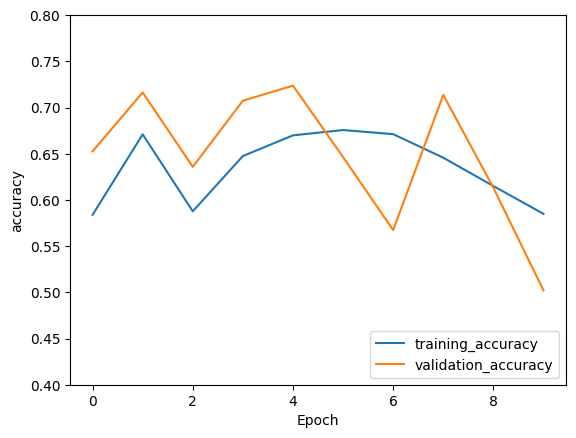

In [573]:
plot_learning_curve_metric(history.history, 0.4, 0.8)

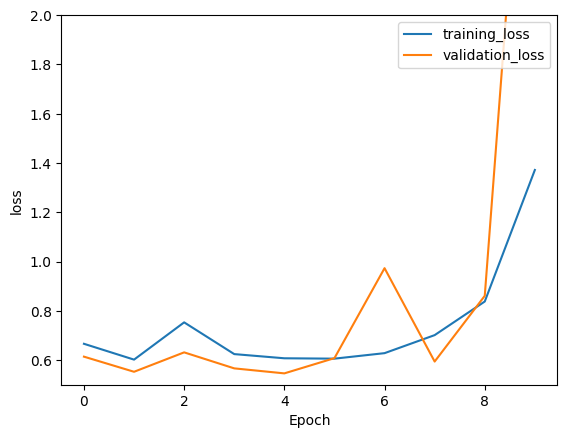

In [571]:
plot_learning_curve_loss(history.history, 0.5, 2)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode='nearest')


    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=64, class_mode='binary', target_size=(150, 150))
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=16, class_mode='binary', target_size=(150, 150))
    
    return train_generator, validation_generator

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.00026),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

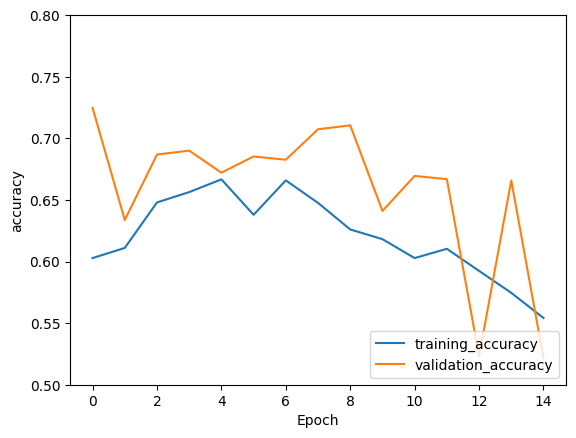

In [534]:
plot_learning_curve_metric(history.history, 0.5, 0.8)

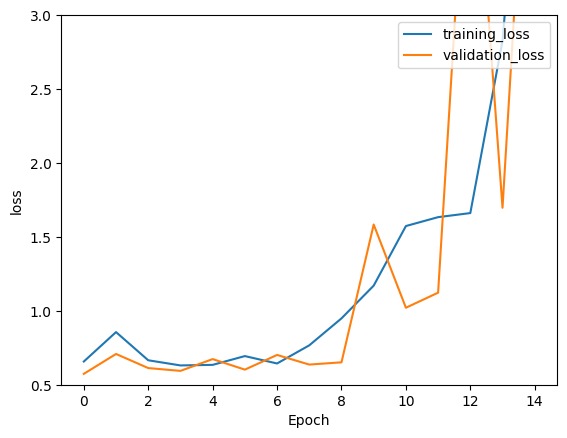

In [536]:

plot_learning_curve_loss(history.history, 0.5, 3)


In [ ]:

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode='nearest')


    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=128, class_mode='binary', target_size=(150, 150))
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=32, class_mode='binary', target_size=(150, 150))
    
    return train_generator, validation_generator

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001, momentum=0.62),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    

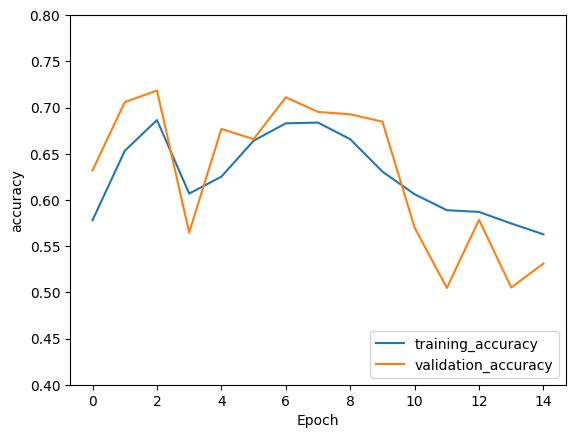

In [543]:
plot_learning_curve_metric(history.history, 0.4, 0.8)

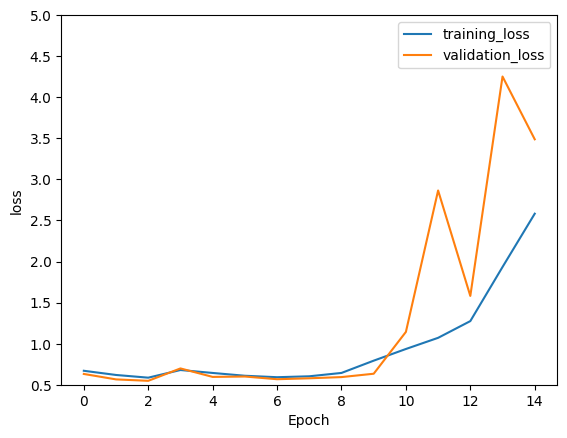

In [547]:
plot_learning_curve_loss(history.history, 0.5, 5)

With the following setup

train_datagen = ImageDataGenerator(rescale=1./255)
    # , rotation_range = 40,
    #                                  width_shift_range = 0.2,
    #                                  height_shift_range = 0.2,
    #                                  shear_range = 0.2,
    #                                  zoom_range = 0.2,
    #                                  horizontal_flip = True,
    #                                  fill_mode='nearest'
    # 

    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=64, class_mode='binary', target_size=(150, 150))
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=16, class_mode='binary', target_size=(150, 150))
    
    return train_generator, validation_generator

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        # tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


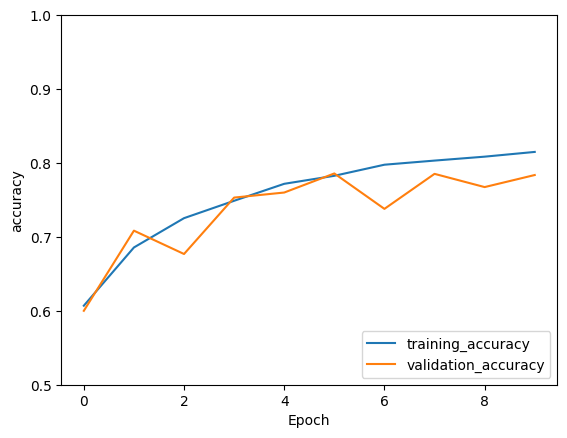

In [429]:
plot_learning_curve_metric(history.history, 0.5, 1)

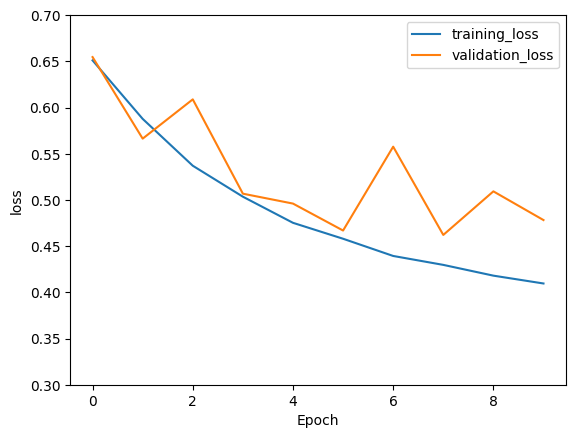

In [432]:

plot_learning_curve_loss(history.history, 0.3, 0.7)

In [ ]:
With the following setup

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode='nearest')


    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=64, class_mode='binary', target_size=(150, 150))
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=16, class_mode='binary', target_size=(150, 150))
    
    return train_generator, validation_generator

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        # tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.00026),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


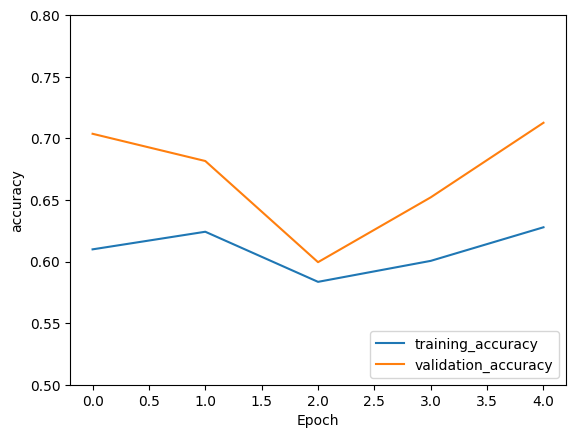

In [451]:
plot_learning_curve_metric(history.history, 0.5, 0.8)

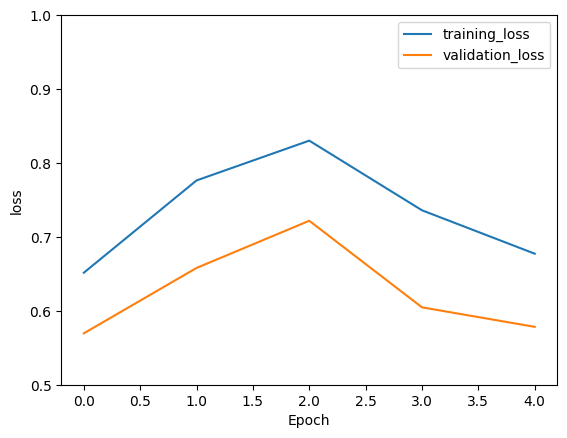

In [453]:

plot_learning_curve_loss(history.history, 0.5, 1)


In [ ]:

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode='nearest')


    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=64, class_mode='binary', target_size=(150, 150))
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=16, class_mode='binary', target_size=(150, 150))
    
    return train_generator, validation_generator

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        # tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


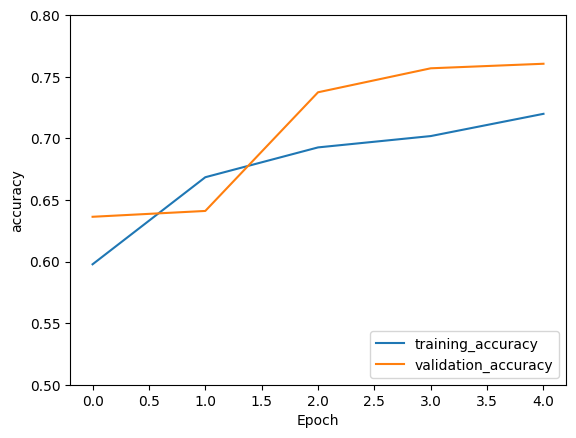

In [465]:
plot_learning_curve_metric(history.history, 0.5, 0.8)

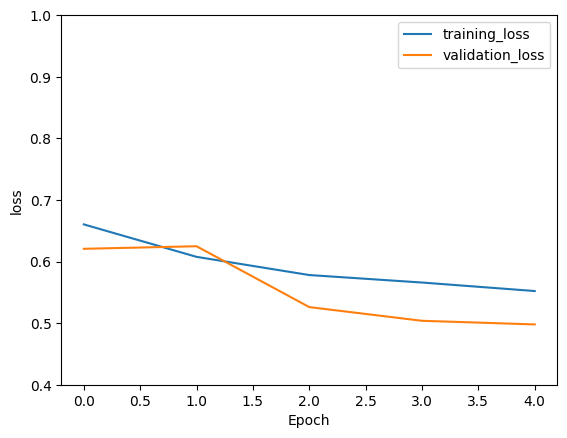

In [468]:

plot_learning_curve_loss(history.history, 0.4, 1)


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode='nearest')


    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=64, class_mode='binary', target_size=(150, 150))
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=16, class_mode='binary', target_size=(150, 150))
    
    return train_generator, validation_generator

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        # tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.00015),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

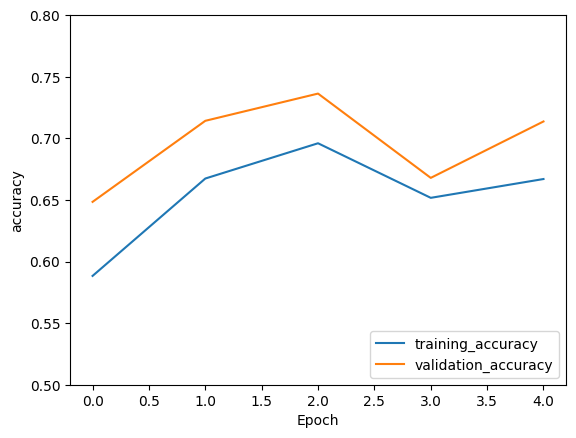

In [490]:
plot_learning_curve_metric(history.history, 0.5, 0.8)

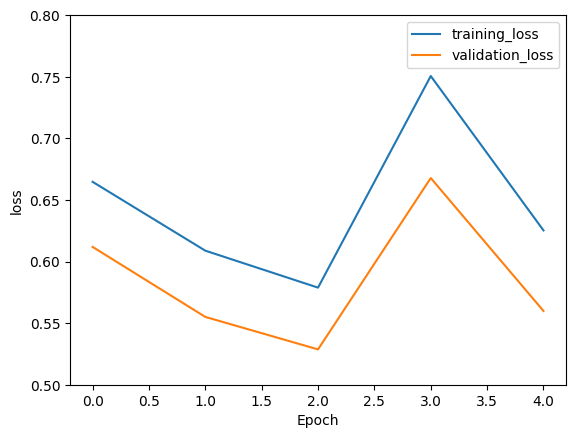

In [491]:

plot_learning_curve_loss(history.history, 0.5, 0.8)


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode='nearest')


    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=128, class_mode='binary', target_size=(150, 150))
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=32, class_mode='binary', target_size=(150, 150))
    
    return train_generator, validation_generator

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        # tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001, momentum=0.5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

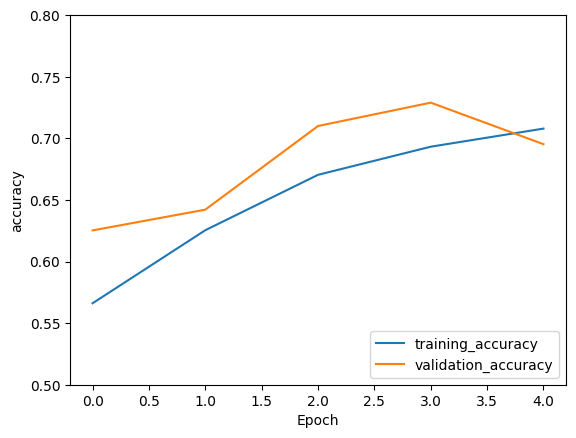

In [506]:
plot_learning_curve_metric(history.history, 0.5, 0.8)

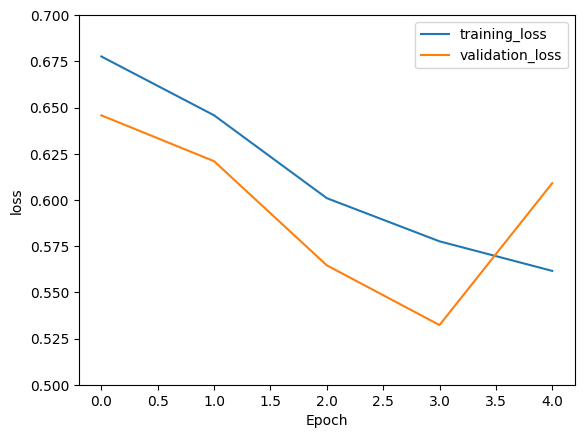

In [508]:

plot_learning_curve_loss(history.history, 0.5, 0.7)


## This seems to work. Although would like to improve the accuracy beyond 85%

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode='nearest')


    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=128, class_mode='binary', target_size=(150, 150))
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=32, class_mode='binary', target_size=(150, 150))
    
    return train_generator, validation_generator

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001, momentum=0.62),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


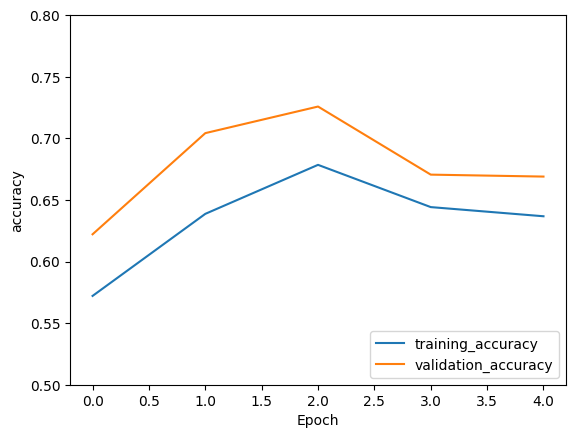

In [516]:
plot_learning_curve_metric(history.history, 0.5, 0.8)

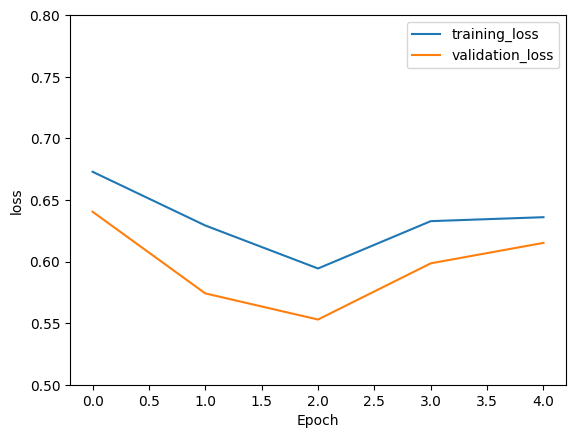

In [517]:
plot_learning_curve_loss(history.history, 0.5, 0.8)

In [ ]:
With this setup - trained it for 15 epochs
    
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode='nearest')


    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=128, class_mode='binary', target_size=(150, 150))
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=32, class_mode='binary', target_size=(150, 150))
    
    return train_generator, validation_generator

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001, momentum=0.62),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


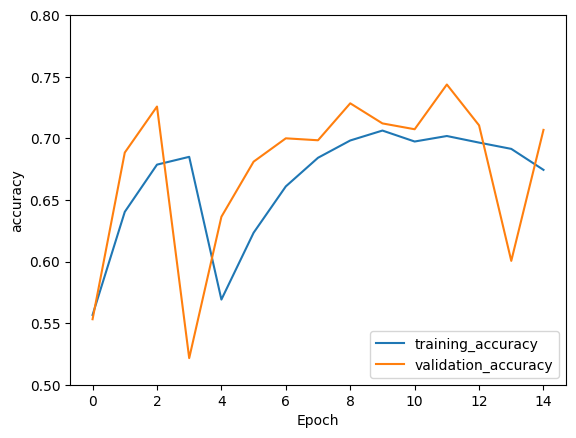

In [526]:
plot_learning_curve_metric(history.history, 0.5, 0.80)

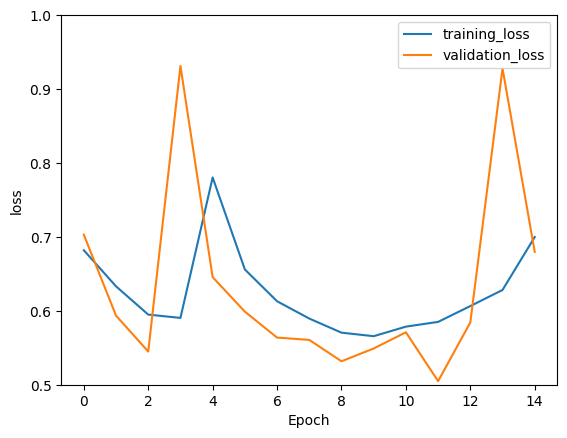

In [528]:

plot_learning_curve_loss(history.history, 0.5, 1)


## With the following setup

train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=64, class_mode='binary', target_size=(150, 150))
    

validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=64, class_mode='binary', target_size=(150, 150))

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


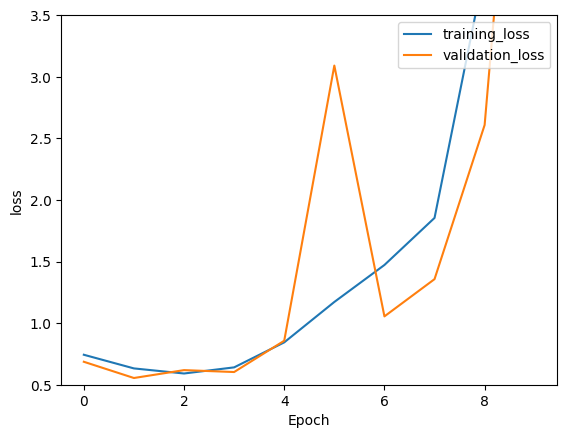

In [154]:
plot_learning_curve_loss(history.history, 0.5, 3.5)

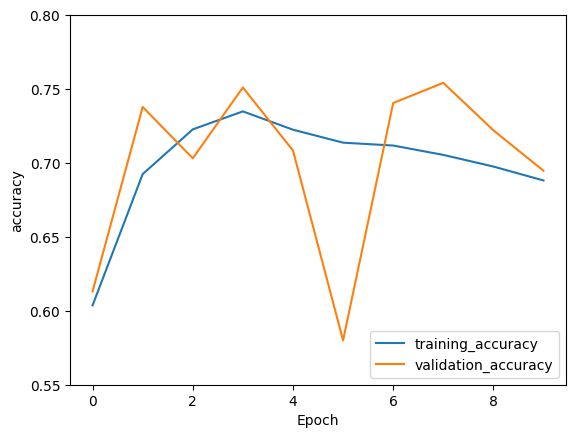

In [159]:
plot_learning_curve_metric(history.history, 0.55, 0.80)


## With the following setup

train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=64, class_mode='binary', target_size=(150, 150))
    


validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=64, class_mode='binary', target_size=(150, 150))

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])



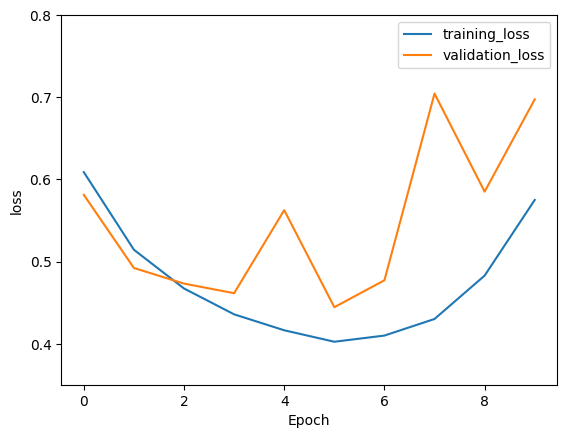

In [170]:

plot_learning_curve_loss(history.history, 0.35, 0.8)


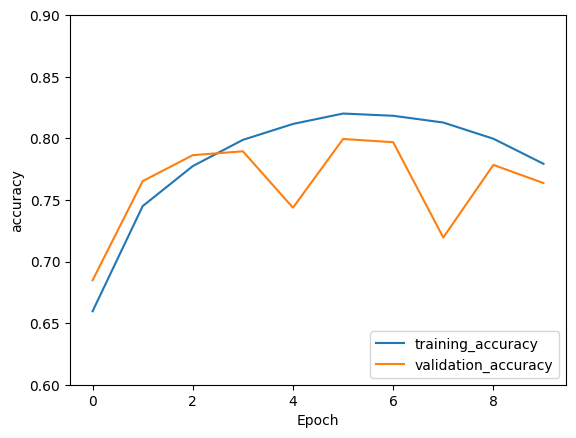

In [168]:

plot_learning_curve_metric(history.history, 0.6, 0.9)


In [ ]:
## With the following setup

train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=128, class_mode='binary', target_size=(150, 150))
    
validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=64, class_mode='binary', target_size=(150, 150))

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0002),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    
    

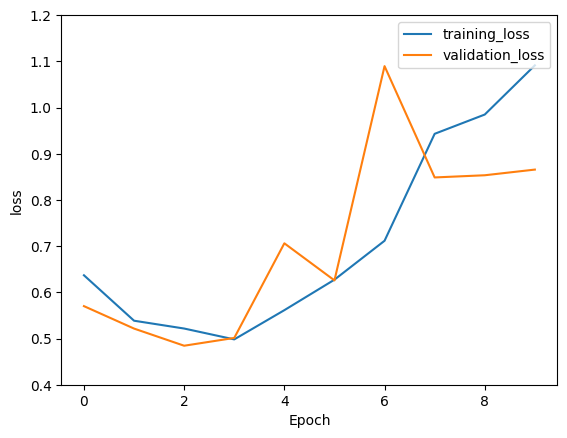

In [182]:
plot_learning_curve_loss(history.history, 0.4, 1.2)

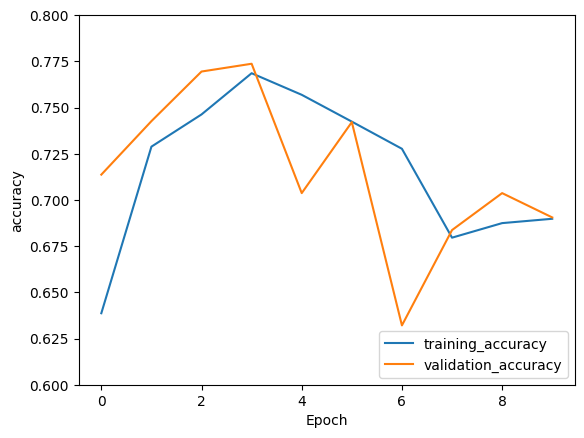

In [184]:
plot_learning_curve_metric(history.history, 0.6, 0.8)

## With the following setup: 

# Training time:  0:14:10.915226

train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=256, class_mode='binary', target_size=(150, 150))

validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=64, class_mode='binary', target_size=(150, 150))

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])



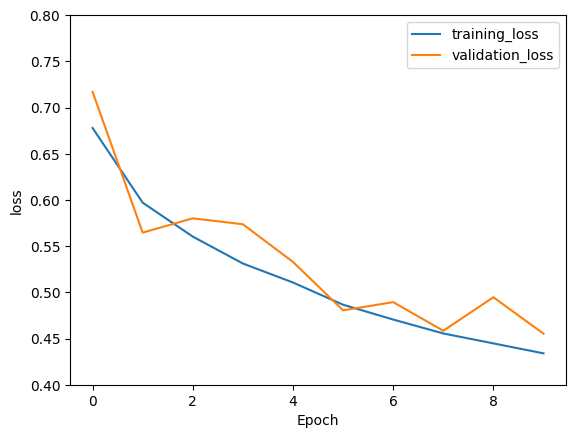

In [203]:

plot_learning_curve_loss(history.history, 0.4, 0.8)


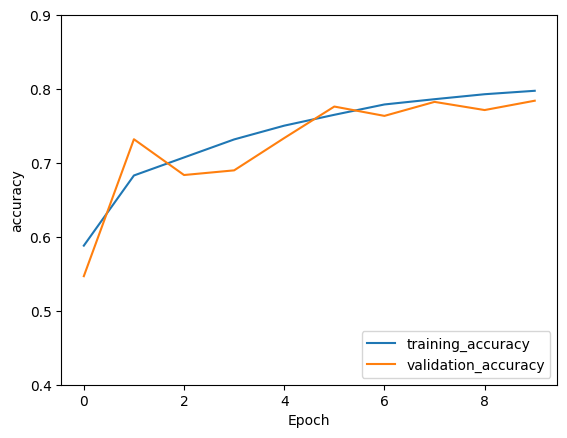

In [207]:

plot_learning_curve_metric(history.history, 0.4, 0.9)


## With the following setup - this setup without augmentation seems to be the best performing one so far

train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=256, class_mode='binary', target_size=(150, 150))

validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=128, class_mode='binary', target_size=(150, 150))

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])



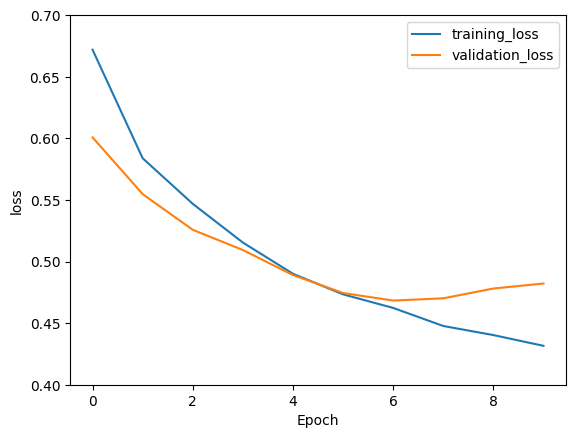

In [214]:

plot_learning_curve_loss(history.history, 0.4, 0.7)


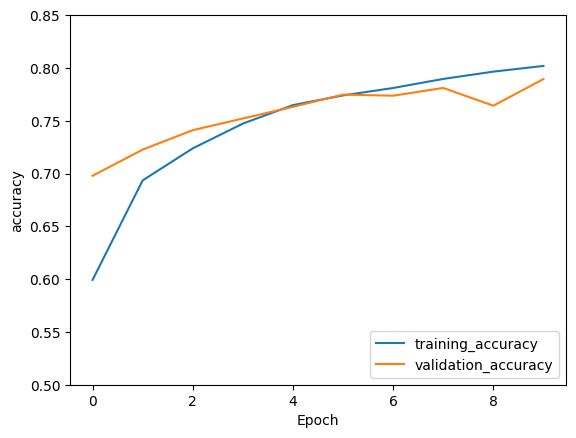

In [217]:

plot_learning_curve_metric(history.history, 0.5, 0.85)


In [ ]:
Primarily with a Dropout layer in this architecture

train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=256, class_mode='binary', target_size=(150, 150))
validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=128, class_mode='binary', target_size=(150, 150))
    
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.0001),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


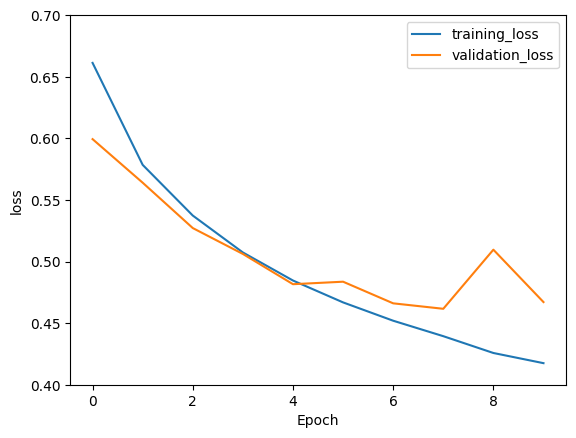

In [222]:

plot_learning_curve_loss(history.history, 0.4, 0.7)


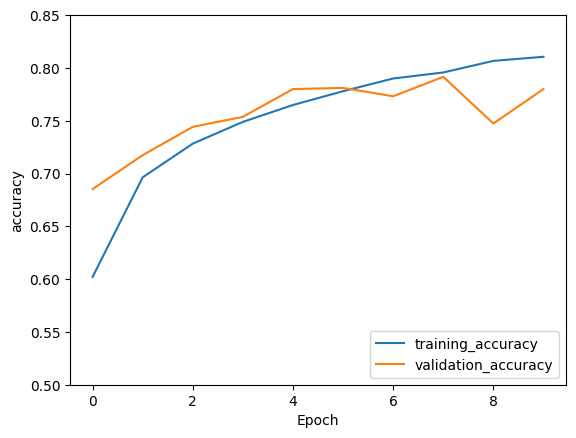

In [223]:
plot_learning_curve_metric(history.history, 0.5, 0.85)

In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

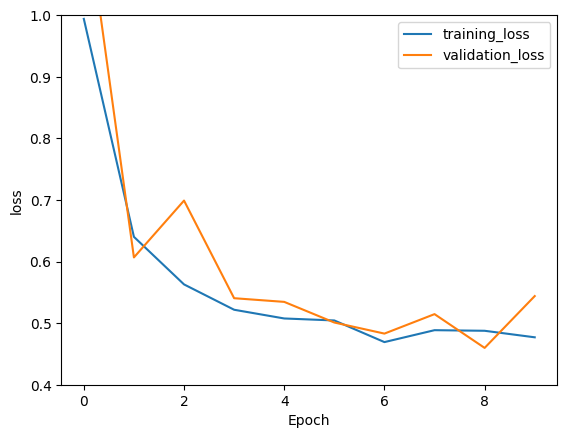

In [238]:
plot_learning_curve_loss(history.history, 0.4, 1)

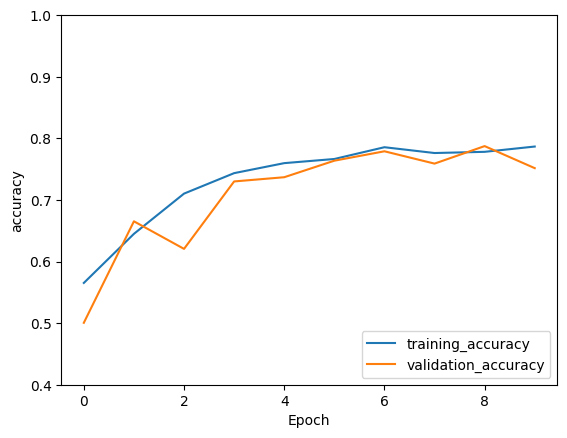

In [239]:
plot_learning_curve_metric(history.history, 0.4, 1)

In [ ]:
With the following setup

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


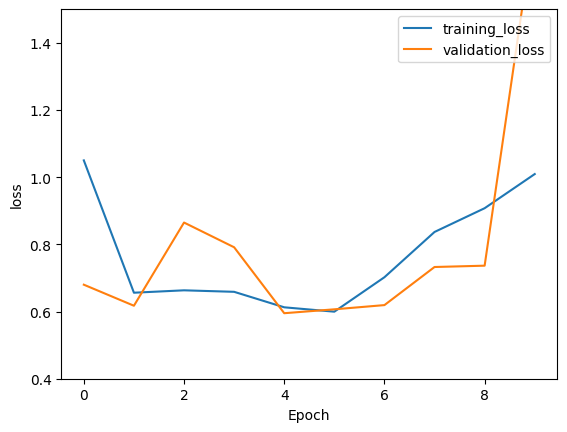

In [246]:

plot_learning_curve_loss(history.history, 0.4, 1.5)


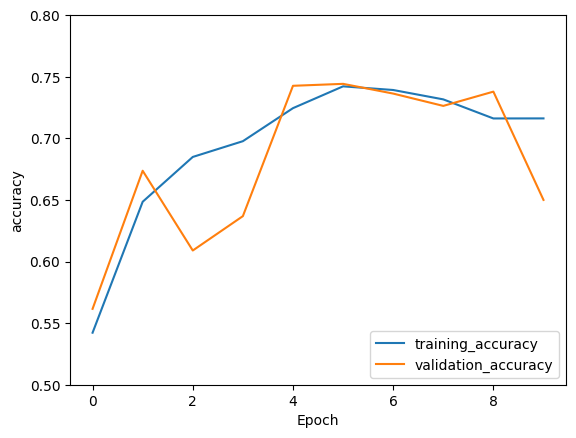

In [249]:

plot_learning_curve_metric(history.history, 0.5, 0.8)


## With the following setup

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


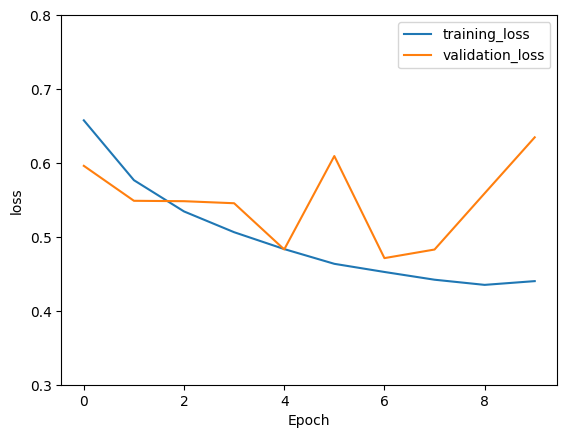

In [255]:

plot_learning_curve_loss(history.history, 0.3, 0.8)


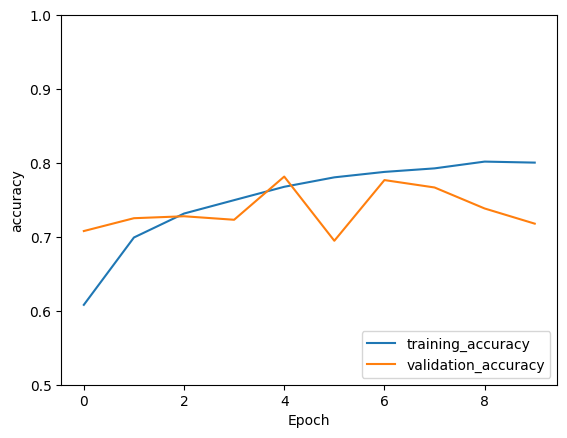

In [257]:

plot_learning_curve_metric(history.history, 0.5, 1)


## With Augmentation

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=256, class_mode='binary', target_size=(150, 150))
    
validation_datagen = ImageDataGenerator(rescale=1./255)
    
validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=128, class_mode='binary', target_size=(150, 150))

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])



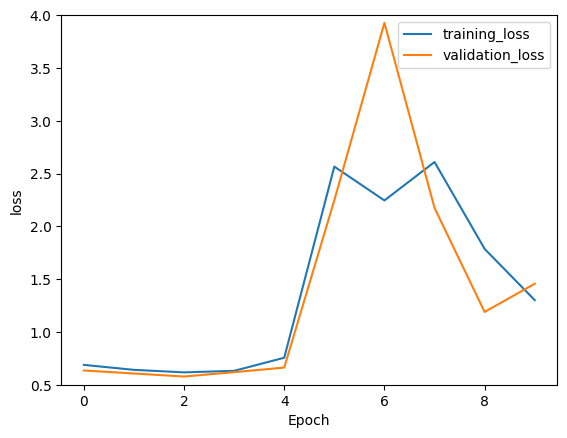

In [268]:

plot_learning_curve_loss(history.history, 0.5, 4)


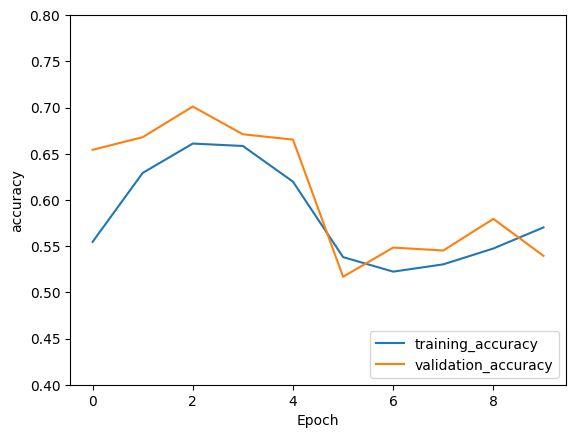

In [271]:

plot_learning_curve_metric(history.history, 0.4, 0.8)


In [ ]:
This looks decent 

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=128, class_mode='binary', target_size=(150, 150))
    
validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=32, class_mode='binary', target_size=(150, 150))
    

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
  model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.00016),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


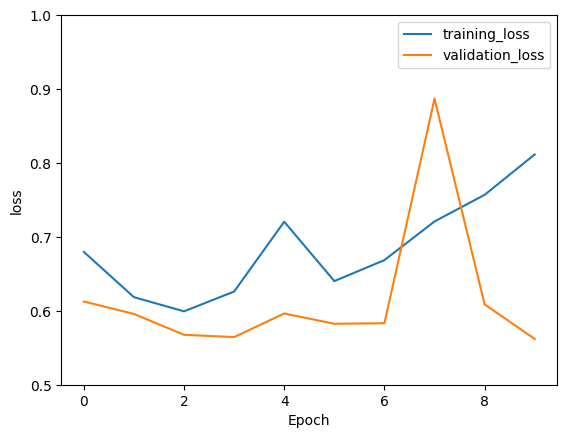

In [277]:

plot_learning_curve_loss(history.history, 0.5, 1)


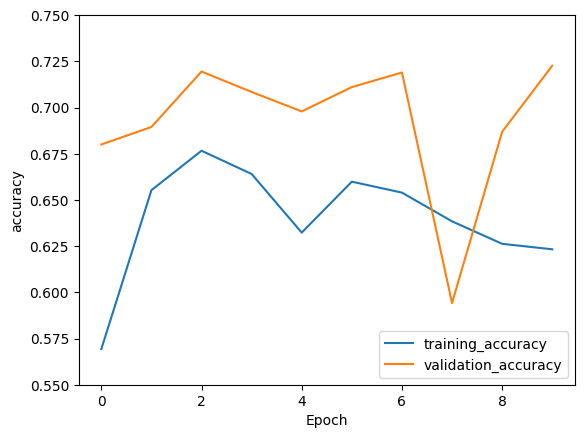

In [279]:

plot_learning_curve_metric(history.history, 0.55, 0.75)


In [ ]:
With this setup here

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode='nearest')

    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=128, class_mode='binary', target_size=(150, 150))
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=32, class_mode='binary', target_size=(150, 150))
    
    return train_generator, validation_generator

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0016),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


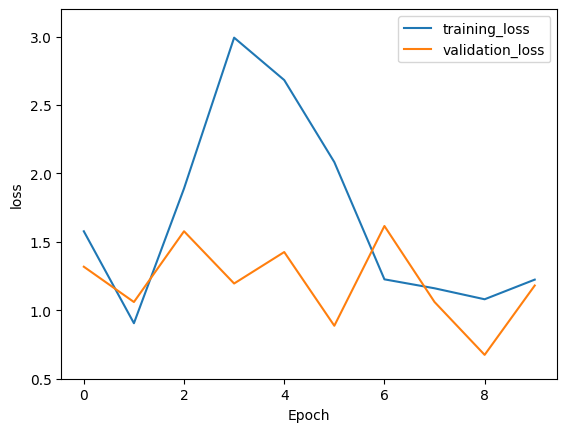

In [297]:
plot_learning_curve_loss(history.history, 0.5, 3.2)

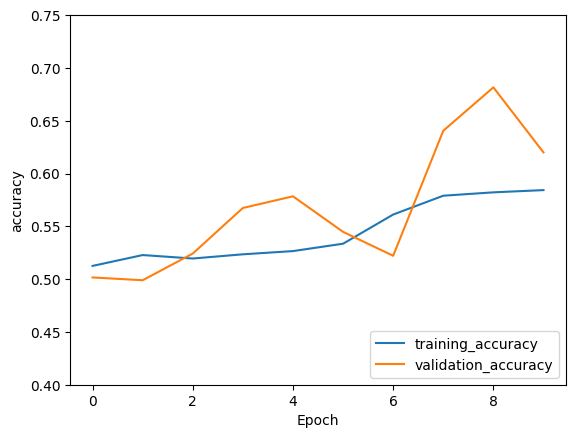

In [300]:

plot_learning_curve_metric(history.history, 0.4, 0.75)


In [ ]:

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode='nearest')

    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=128, class_mode='binary', target_size=(150, 150))
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=32, class_mode='binary', target_size=(150, 150))
    
    return train_generator, validation_generator

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.00026),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


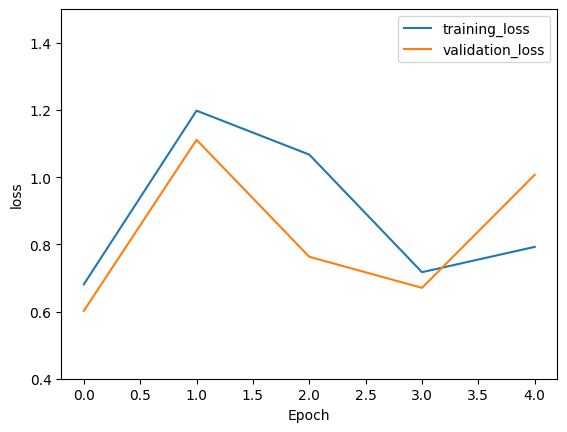

In [306]:
plot_learning_curve_loss(history.history, 0.4, 1.5)

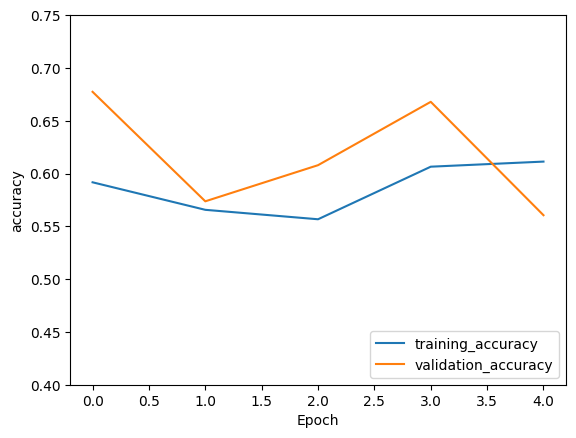

In [307]:

plot_learning_curve_metric(history.history, 0.4, 0.75)


In [ ]:

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode='nearest')

    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=128, class_mode='binary', target_size=(150, 150))
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=32, class_mode='binary', target_size=(150, 150))
    
    return train_generator, validation_generator

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.002),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


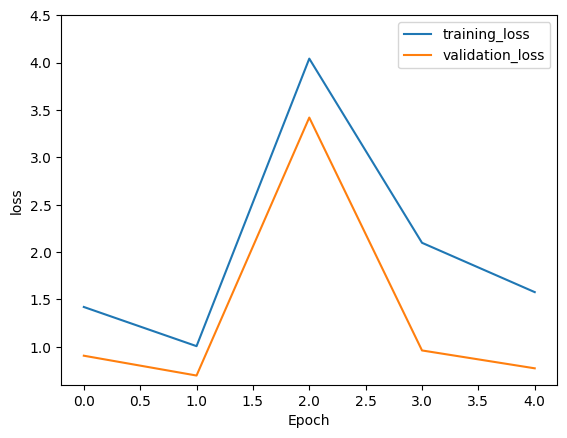

In [316]:

plot_learning_curve_loss(history.history, 0.6, 4.5)


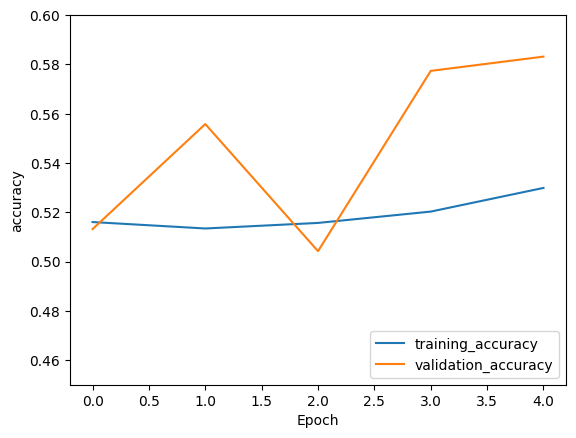

In [318]:

plot_learning_curve_metric(history.history, 0.45, 0.60)


## With the following setup

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=128, class_mode='binary', target_size=(150, 150))
    
validation_datagen = ImageDataGenerator(rescale=1./255)
    
validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=64, class_mode='binary', target_size=(150, 150))
    

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.00023),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


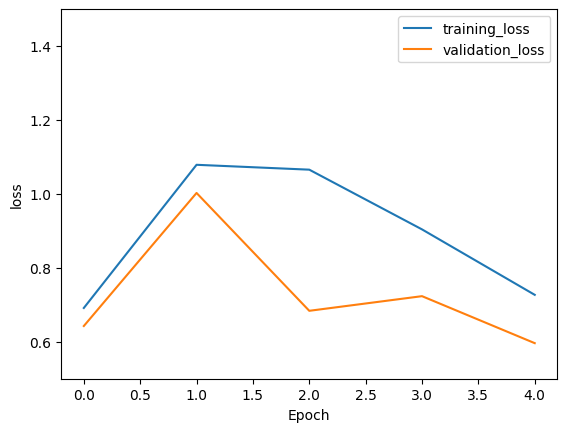

In [325]:

plot_learning_curve_loss(history.history, 0.5, 1.5)


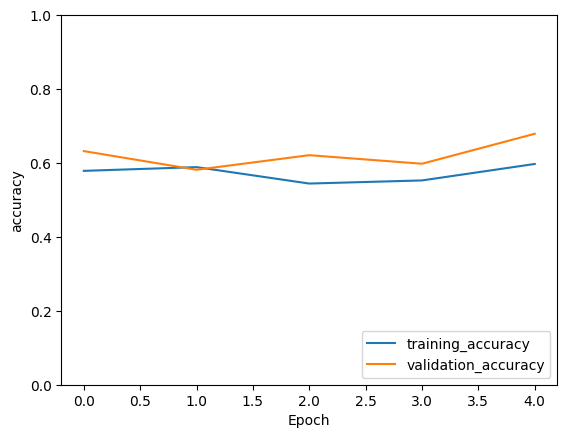

In [327]:

plot_learning_curve_metric(history.history, 0, 1)


In [ ]:

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode='nearest')
    

    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=128, class_mode='binary', target_size=(150, 150))
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=64, class_mode='binary', target_size=(150, 150))
    
    return train_generator, validation_generator

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(192, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(72, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(48, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.00023),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


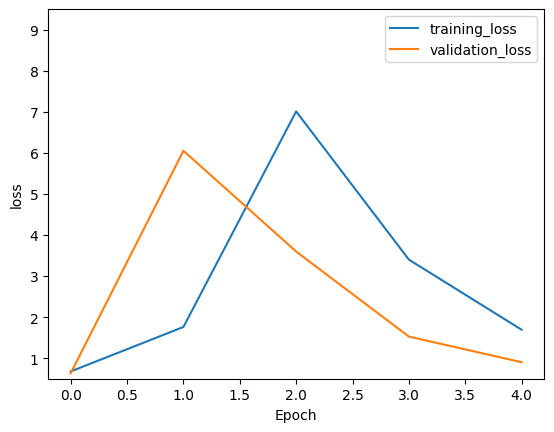

In [366]:
plot_learning_curve_loss(history.history, 0.5, 9.5)

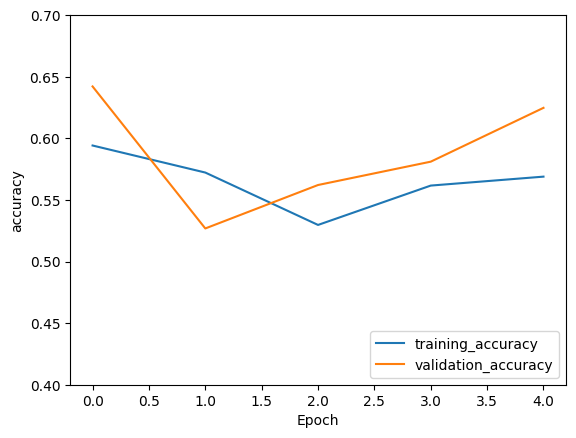

In [370]:

plot_learning_curve_metric(history.history, 0.4, 0.7)


## With the following setup

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode='nearest')
    

    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=128, class_mode='binary', target_size=(150, 150))
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=64, class_mode='binary', target_size=(150, 150))
    
    return train_generator, validation_generator

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.00023),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.93):
            print("\nReached 93% accuracy so cancelling training!")
            self.model.stop_training = True


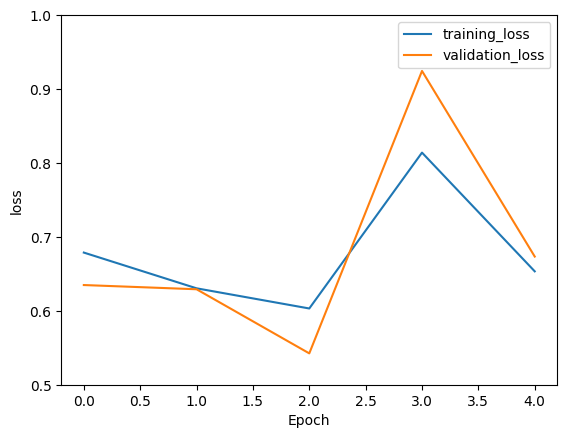

In [379]:
plot_learning_curve_loss(history.history, 0.5, 1)

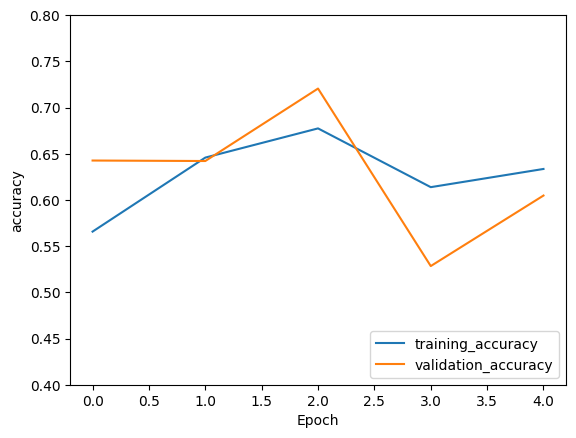

In [382]:
plot_learning_curve_metric(history.history, 0.4, 0.8)

In [ ]:

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode='nearest')
    

    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=32, class_mode='binary', target_size=(150, 150))
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=16, class_mode='binary', target_size=(150, 150))
    
    return train_generator, validation_generator

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.00013),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


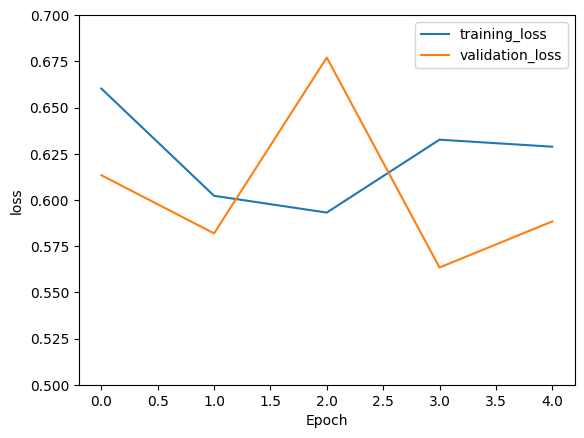

In [389]:

plot_learning_curve_loss(history.history, 0.5, 0.7)


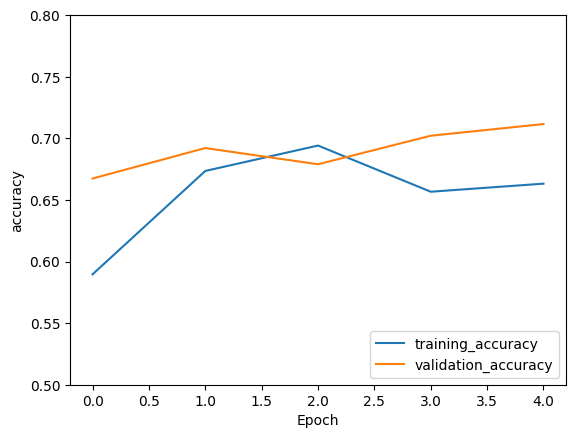

In [391]:
plot_learning_curve_metric(history.history, 0.5, 0.8)

In [ ]:

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode='nearest')
    

    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=64, class_mode='binary', target_size=(150, 150))
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=16, class_mode='binary', target_size=(150, 150))
    
    return train_generator, validation_generator

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.00013),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


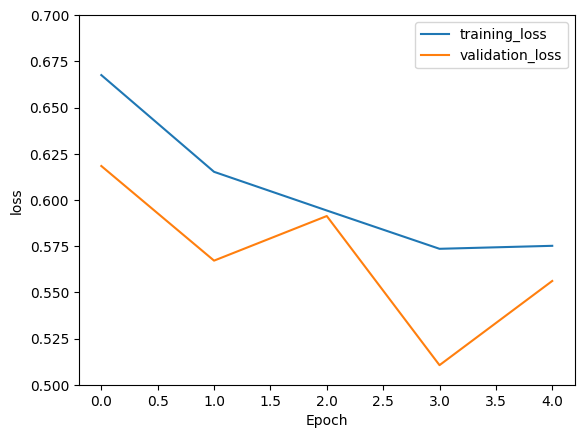

In [405]:

plot_learning_curve_loss(history.history, 0.5, 0.7)


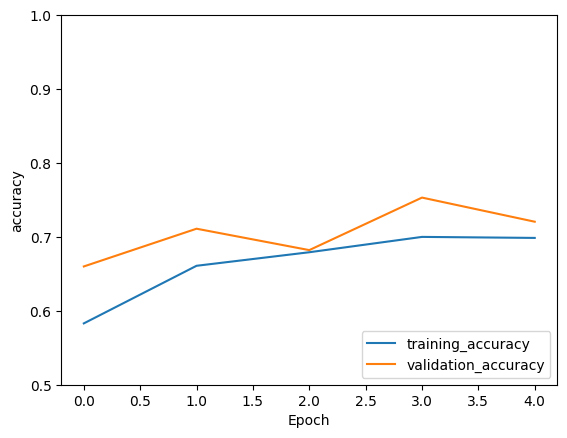

In [407]:

plot_learning_curve_metric(history.history, 0.5, 1)


In [ ]:
##Trained this architecture for 10 epochs

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode='nearest')
    

train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=64, class_mode='binary', target_size=(150, 150))
    

validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=16, class_mode='binary', target_size=(150, 150))
    

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.00013),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


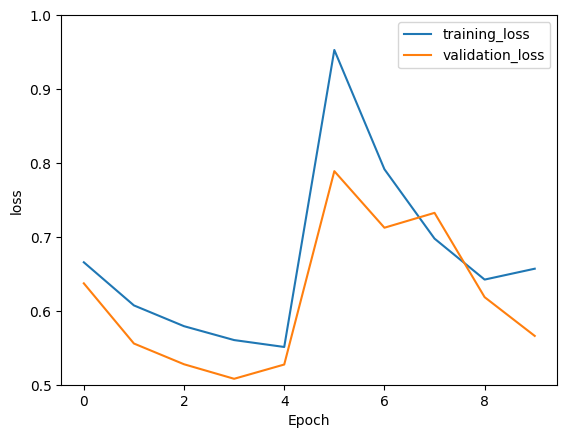

In [414]:
plot_learning_curve_loss(history.history, 0.5, 1)

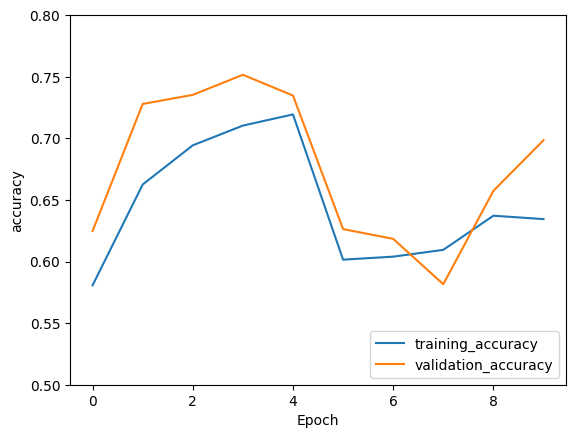

In [416]:

plot_learning_curve_metric(history.history, 0.5, 0.8)


In [334]:
for i in np.arange(0.00015, 0.0003, 0.00001):
    print(i)

0.00015
0.00015999999999999999
0.00016999999999999999
0.00017999999999999998
0.00018999999999999998
0.00019999999999999998
0.00020999999999999998
0.00021999999999999998
0.00022999999999999998
0.00023999999999999998
0.00025
0.00026
0.00026999999999999995
0.00028
0.00029


In [519]:
del model_builder, tuner


## Hyperparameter Tuning - using Keras.Tuner

In [357]:

def model_builder(hp):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(hp.Int('first_unit', min_value=32, max_value=228, step=32), (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(hp.Int('second_unit', min_value=8, max_value=124, step=8), (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(hp.Int('third_unit', min_value=8, max_value=124, step=8), (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.00023), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [337]:
os.getcwd()

'/Users/chidam_sp/PycharmProjects/pythonProject2/Convolutional Neural Net_TF'

In [345]:
TRAINING_DIR, VALIDATION_DIR

('/Users/chidam_sp/PycharmProjects/pythonProject2/Convolutional Neural Net_TF/cats_dogs_data_split/training/',
 '/Users/chidam_sp/PycharmProjects/pythonProject2/Convolutional Neural Net_TF/cats_dogs_data_split/validation/')

In [346]:

train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)


Found 22598 images belonging to 2 classes.
Found 1900 images belonging to 2 classes.


In [358]:
import datetime
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner = kt.BayesianOptimization(model_builder, objective='val_loss', max_trials=5, directory='cats_dogs_tuning_logs', project_name='cats_dogs_augmentation_apr9', overwrite=True)  
start_time = datetime.datetime.now()
tuner.search(train_generator, validation_data=validation_generator, epochs=10, callbacks=[stop_early], verbose=1)
end_time = datetime.datetime.now()
print("Training time: ", end_time - start_time)


Trial 5 Complete [00h 11m 33s]
val_loss: 0.558583676815033

Best val_loss So Far: 0.5511623024940491
Total elapsed time: 01h 01m 45s
Training time:  1:01:45.201745


In [359]:

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


In [360]:

for hp in best_hps.space:
  print(f"{hp.name}: {best_hps.get(hp.name)}")


first_unit: 192
second_unit: 72
third_unit: 48


In [ ]:

hypermodel = tuner.hypermodel.build(best_hps)


In [ ]:

hypermodel.summary()


In [ ]:

After hyperparameter tuning step, we train the hypermodel (from the tuning step) with the best discovered parameters on the training and validation data again before saving it as the final model.


In [ ]:
You will save this as the final model. The hypermodel is our final model

history_epochs = hypermodel.fit(train_images_split, train_labels_split, epochs=50, batch_size=256, 
                                validation_data=(val_images_split, val_labels_split))



In [ ]:

history = model.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator, verbose=2, callbacks=[callbacks])


In [2]:
from tensorflow.keras.backend import clear_session
clear_session()

In [6]:
del model, history
import gc
gc.collect()

970